# Another introduction to FFTs, leading to a discussion of noise

Each cell in this notebook needs to be executed in sequence. We begin by importing the libraries that we will be using.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Make the plots appear inline.

%matplotlib inline

We are now going to generate some one-dimensional data arrays - representing equally time-spaced samples from an experiment - and see what happens when we calculate their FFTs.

Incidentally, the first "F" in "FFT" stands for "Fast", and this is because it is calculated using a clever, fast, algorithm published in 1965 by Cooley and Tukey. The algorithm reduces the time required to calculate the Fourier transform by realising that many of the terms in the calculation are duplicated. Its running time goes as $O(N\log N)$ rather than $O(N^2)$, so it becomes increasingly valuable for large numbers of samples.

The Cooley-Tukey algorithm works best for sample sizes that are a power of two, so it can be an advantage to pad your samples with zeros up to the next power of two, or truncate down to a lower power of two. The algorithm works worst for a prime number of samples.

Anyway... back to our explorations...

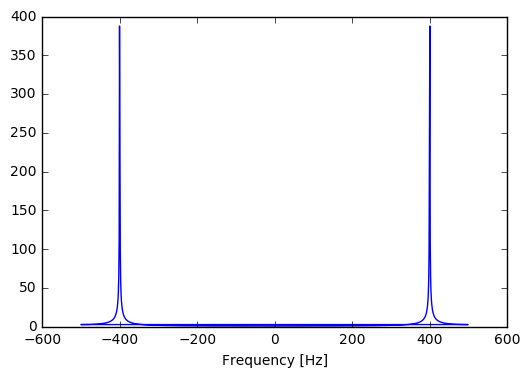

In [2]:
# Choose a nice large number of data samples, making it
# a power of 2 which is ideal for the FFT algorithm.

numSamples = 2**10

# Set the time between samples to 0.001 second. This gives
# us a Nyquist frequency (the highest frequency we can sample
# without aliasing) of 500 Hz.

dt = 0.001

# Now generate an array of times, beginning at zero, 
# separated by dt.

t = np.linspace(0, dt * (numSamples - 1), numSamples)

# In Fourier space, this array of times will correspond to
# an array of frequencies, so lets calculate that.

f = np.fft.fftfreq(t.size, dt)

# Ok, so we are now ready to create a signal. Let's try 
# a sine wave at 400 Hz.

freqHz = 400.0
y = np.sin(2 * np.pi * freqHz * t)

# Now find the FFT of the signal, and plot its absolute
# value versus frequency.

fft = np.fft.fft(y)
plt.plot(f, abs(fft))
plt.xlabel("Frequency [Hz]")
plt.show()

Notice how in the above plot we have a nice peak at 400 Hz, which is what you would hope given that we injected a signal at this frequency. We also have one at -400 Hz. In fact, for real data samples the -ve frequency amplitudes are just the mirror reflection of the +ve ones. 

The negative frequencies only contain non-redundant information for complex input signals, and since we will almost always be dealing with real input signals (i.e., from measurements of voltages, currents, etc), we can ignore the negative frequencies, and just plot the +ve ones as follows:

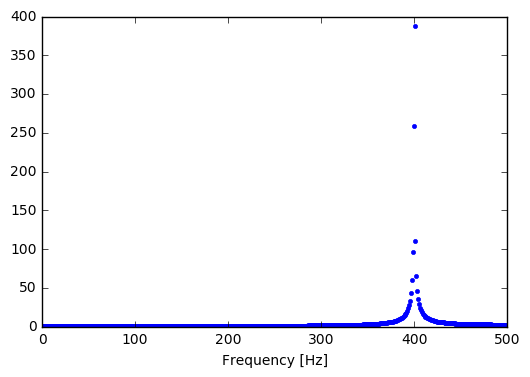

In [3]:
# The +ve frequencies are in the first half of the
# FFT arrays. Note that we use integer division (the 
# "//" operator) to find the correct array slice endpoint.

plt.plot(f[:numSamples//2], abs(fft[:numSamples//2]), '.')
plt.xlabel("Frequency [Hz]")
plt.show()

In the above plot we have also used dots rather than connecting the lines.

Rather than throwing away have of the FFT output, a better approach is to use the numpy routines `rfft` and `rfftfreq` that are specifically designed for real samples, and return only the positive frequencies. We also multiply the FFT by $2/n$ where $n$ is the number of samples, so that the amplitude is correct.

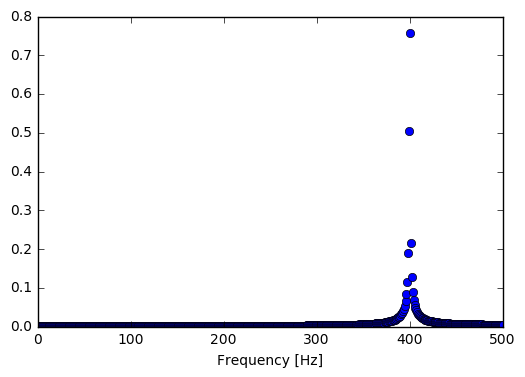

In [4]:
# Find the frequency bins. Note that we are calling 
# rfftfreq, for real samples.

f = np.fft.rfftfreq(t.size, dt)

# Now find the FFT of the signal using rfft, normalise by 
# multiplying by 2/numSamples, and plot the absolute 
# value versus frequency. We use big dots for the plot symbols.

fft = np.fft.rfft(y) * 2 / numSamples
plt.plot(f, abs(fft), 'o')
plt.xlabel("Frequency [Hz]")
plt.show()

### Spectral leakage

You may wonder why in the above plot there is a *distribution* of frequencies in the FFT, whereas we created the signal from a pure sine wave. The reason is that the FFT assumes that the input signal is *periodic*, so even though we only provided 1024 samples, the FFT assumes that the signal continues forever, and is constructed by taking copies of the 1024 samples and adding them to the end of our original 1024, and so on. Unless we choose the input frequency very carefully, there will be a discontinuity at the join, and the FFT will find a range of sine waves that do a good job of trying to follow the discontinuity.

The spilling of power into neighbouring frequencies is an example of *spectral leakage*. Sampling the input waveform more frequently does not help. What does help is to increase the observation time, and in the limit that you sample for infinity seconds, you get a perfect result!

To explore this further, let's choose a frequency near 400 Hz that gives an exact integer number of sine waves in 1024 samples at 0.001 second per sample.

the frequency is 400.390625 Hz


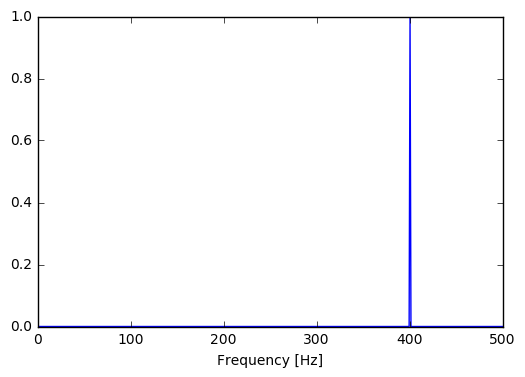

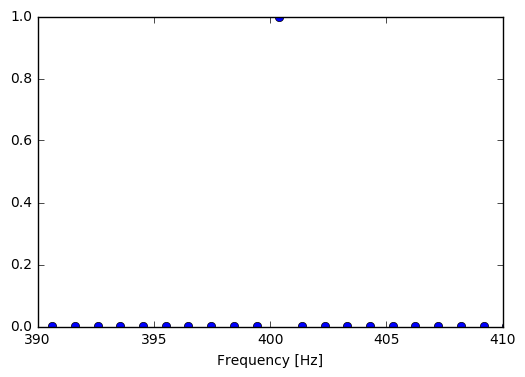

In [5]:
# Choose a frequency near 400 Hz to fit an integral number 
# (410) of cycles in 1024 samples. The number "410" was 
# chosen since it is about 1.024 times 400.

freqHz = 410 / (1024 * 0.001)
print("the frequency is", freqHz, "Hz")

# Create the signal, as before.

y = np.sin(2 * np.pi * freqHz * t)
f = np.fft.rfftfreq(t.size, dt)

# Calculate the FFT and plot it.

fft = np.fft.rfft(y) * 2 / numSamples

plt.plot(f, abs(fft))
plt.xlabel("Frequency [Hz]")
plt.show()

# Plot it again, this time zooming in on the relevant 
# section near 400 Hz.

plt.plot(f, abs(fft), 'o')
plt.xlim(390, 410)
plt.xlabel("Frequency [Hz]")
plt.show()


You can see from the above plots that all the power is now in a single frequency bin in the FFT, since the infinite repetition of our samples has no discontinuities.

Of course, the above example is rather artificial in that we have deliberately chosen the signal frequency, time sampling, and number of samples, to give an exactly integral number of wavelengths. In most experiments you don't know the signal frequency in advance: this is why you are taking the FFT in the first place!

### Using windowing functions to mitigate spectral leakage

An interesting way of mitigating the effect of spectral leakage is to multiply the sample array with a *window function* that typically has a value of 1.0 at the mid-point of the time samples, and reduces to zero at the first and last sample. Up till now, our window function has been *rectangular*, i.e., 1.0 everywhere. It turns out that with an appropriate choice of function, it is possible to modify how the apparent signal from spectral leakage is distributed in the frequency domain. This can help, e.g., in trying to distinguish two frequencies that are close together, where the lower amplitude one would otherwise be swamped by spectral leakage from the stronger one.

There are many different window functions in use, e.g., rectangular, triangular, Hamming, Hann, and a variety of other bell-shaped curves. An excellent description is found in [the wikipedia article](https://en.wikipedia.org/wiki/Window_function).

numpy has support for the following window functions: Bartlett (very similar to a triangular function, except the end-points are zero), Blackmann, Hamming, Hanning (also called Hann, to distinguish it from Hamming), and Kaiser (which takes a parameter called "beta" that alters the shape of the function). To use these functions, simply call the appropriate routine to generate the window function, and multiply your sample array with it. Then take the FFT.

The following program applies all four of the numpy window functions to our 400 Hz test signal. We plot the window functions, and then plot the FFTs after windowing.

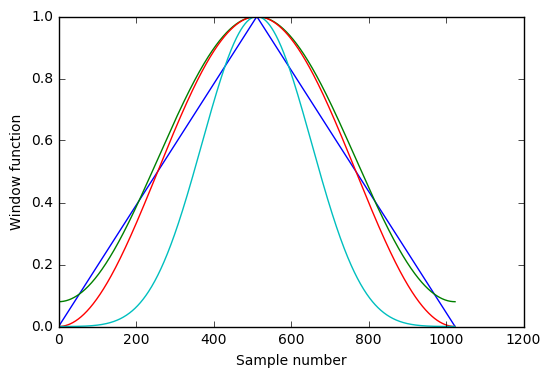

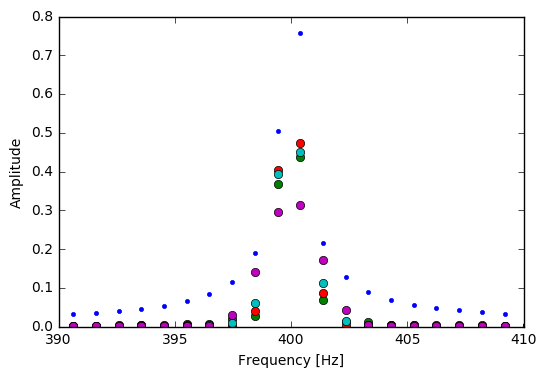

In [17]:
# Create the four window functions that numpy provides.
# Use a beta of 14 for the Kaiser function.

windowBartlett = np.bartlett(numSamples)
windowHamming  = np.hamming(numSamples)
windowHanning  = np.hanning(numSamples)
windowKaiser   = np.kaiser(numSamples, 14)

# Plot the window functions.

plt.plot(windowBartlett)
plt.plot(windowHamming)
plt.plot(windowHanning)
plt.plot(windowKaiser)
plt.xlabel("Sample number")
plt.ylabel("Window function")
plt.show()

# Generate our test data, at 400 Hz so we have a non-integral
# number of wavelengths, and hence spectral leakage.

freqHz = 400.0
y = np.sin(2 * np.pi * freqHz * t)

# Calculate the FFT for each window function (beginning
# with the rectangular window).

fft = np.fft.rfft(y) * 2 / numSamples
fftBartlett = np.fft.rfft(y*windowBartlett) * 2 / numSamples
fftHamming  = np.fft.rfft(y*windowHamming)  * 2 / numSamples
fftHanning  = np.fft.rfft(y*windowHanning)  * 2 / numSamples
fftKaiser   = np.fft.rfft(y*windowKaiser)   * 2 / numSamples

# Plot all five FFTs, zooming in on the relevant 
# section near 400 Hz.

plt.plot(f, abs(fft), '.')
plt.plot(f, abs(fftBartlett), 'o')
plt.plot(f, abs(fftHamming), 'o')
plt.plot(f, abs(fftHanning), 'o')
plt.plot(f, abs(fftKaiser), 'o')
plt.xlim(390, 410)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.show()


Note that the FFTs using the various window functions (large coloured dots) reduce the spectral leakage when compared with the rectangular window (small blue dots). This can be useful, e.g., when trying to detect a small signal on the shoulders of a stronger signal. Each function has distinct advantages, and you should examine the differences carefully if you are in the regime where it really matters. For example, if you are trying to detect a faint signal at a known offset from a strong signal, you could choose a window function that minimises the spectral leakage from the strong signal at the offset frequency.

Using a window function with a FFT is also called *apodization*. The technique can also be applied to optical imaging, and is especially powerful in astronomy when trying to observe very faint objects close to bright ones, e.g., planets orbiting around stars. An appropriate apodization filter essentially changes the diffraction pattern produced by the telescope optics, and can move the power away from particular radii of interest. For example, the following image of a planet orbiting the star Beta Pictoris was taken using an apodizing phase plate coronagraph on the VLT. The half of the image on the right shows the airy diffraction rings, the half of the image on the left has had the power in the diffration rings moved outwards to make a clear region where the planet can be detected.

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/ann1037d.jpg)

Apodization is also used in camera lenses to change the *bokeh* (the nature of the out-of-focus blurring produced by the lens). This can give interesting visual effects, e.g., as in the following image:

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/bokeh.jpg)

# The power spectrum

For many purposes it is more useful to plot the *power spectrum* rather than the amplitude spectrum (i.e., the absolute value of the FFT). Since power goes as the square of the amplitude (think of the data values as representing voltage, in which case the electrical power is proportional to voltage squared), the power spectrum simply comes from squaring the absolute value of the FFT, or equivalently, multiplying the FFT by its complex conjugate.

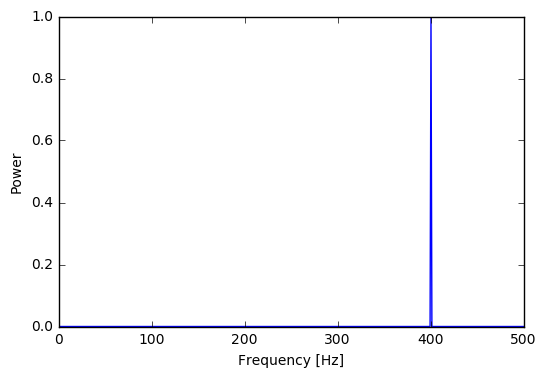

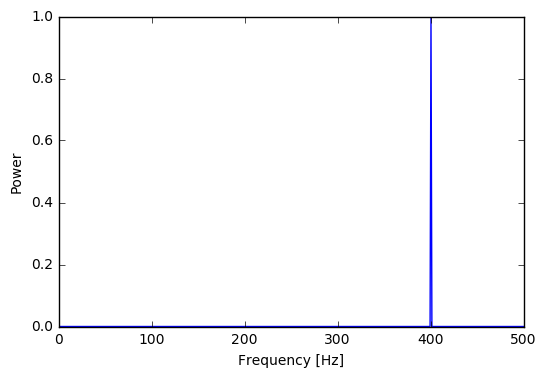

In [6]:
# Plot the power spectrum, i.e., the square of the 
# absolute value of the FFT.

plt.plot(f, abs(fft) ** 2)
plt.ylabel("Power")
plt.xlabel("Frequency [Hz]")
plt.show()

# We get the same result by multiplying the FFT by
# its complex conjugate. We take the real part to 
# stop plot() from complaining about a complex argument
# - the imaginary part should be all zeros, but finite
# precision calculations may leave some small complex
# residuals.

plt.plot(f, np.real(fft * np.conj(fft)))
plt.ylabel("Power")
plt.xlabel("Frequency [Hz]")
plt.show()

As expected, the two plots above are identical, and show a power of 1.0 at the input frequency.

# What do the real and imaginary parts of the FFT mean?

So far we have been plotting the absolute value of the FFT. The absolute value of the FFT at a particular frequency tells us how much signal at that frequency is in the input array. It tells us nothing about the *phase relationship* between the frequencies; very different waveforms can be produced by shifting the phases of the frequencies. For example, the following snippet generates four input waveforms that have identical absolute values of their FFTs, but differ in the phases.

the frequency is 4.8828125 Hz


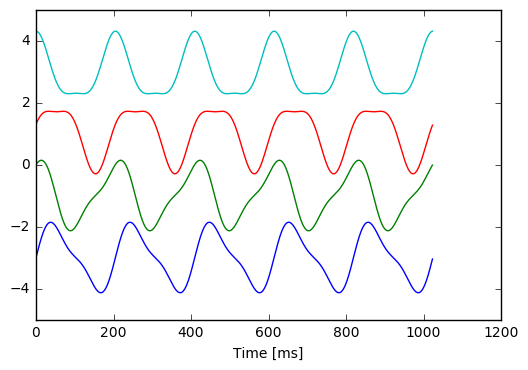

In [7]:
# Chose a frequency that will give us an integral
# number (5) of waves in our 1024 samples.

freqHz = 5 / (1024 * 0.001)
print("the frequency is", freqHz, "Hz")

# Create four signals, with the same frequencies and 
# amplitudes, but different phases. 

y0 = np.sin(2 * np.pi * freqHz * t) + 0.3 * np.sin(2 * np.pi * (freqHz + freqHz) * t)
y1 = np.cos(2 * np.pi * freqHz * t) + 0.3 * np.sin(2 * np.pi * (freqHz + freqHz) * t)
y2 = np.sin(2 * np.pi * freqHz * t) + 0.3 * np.cos(2 * np.pi * (freqHz + freqHz) * t)
y3 = np.cos(2 * np.pi * freqHz * t) + 0.3 * np.cos(2 * np.pi * (freqHz + freqHz) * t)

# Plot the four signals, displacing them in the y direction
# to make them easy to see.

plt.plot(y0 - 3.0)
plt.plot(y1 - 1.0)
plt.plot(y2 + 1.0)
plt.plot(y3 + 3.0)
plt.xlabel("Time [ms]")
plt.show()


As you can see from the above plot, each signal looks quite different from the others, despite being composed of the same input frequencies.

Now lets plot the absolute value, argument, real, and imaginary parts of the FFT for each of these signals. For simplicity I have only shown y0 in this notebook, you need to edit this to explore y1, y2, and y3.

You need to look at the following plots very carefully. The argument plot looks chaotic, but that is simply because the real and imaginary components are at the level of floating-point noise, apart from at the two input frequencies (4.88 Hz and 2 * 4.88 Hz) - so you should only look at the values at these two points. Also, keep an eye on the scaling factor to be applied to the y-axis.

With some careful study you should see the following:

- the absolute value plot is the same for all four signals
- the argument plot shows the phase relationship of the component frequencies
- the real plot shows the cosine component
- the imaginary plot shows minus the sine component

The important thing to take away from all this is that there is nothing mysterious about the complex nature of the FFT. It is simply that you need two numbers (amplitude and phase) to represent a frequency component in a signal, and the easiest way to deal with arrays of two numbers is to use complex numbers. In particular, there is nothing strange or mysterious about the *imaginary* component of an FFT.

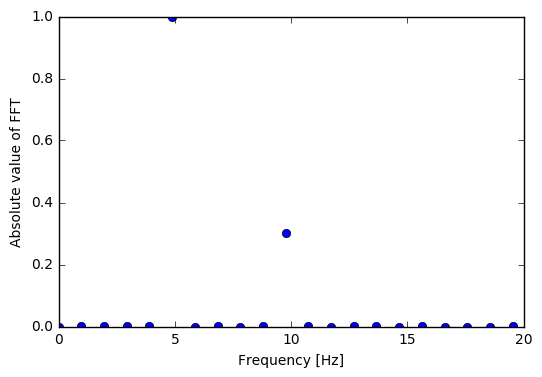

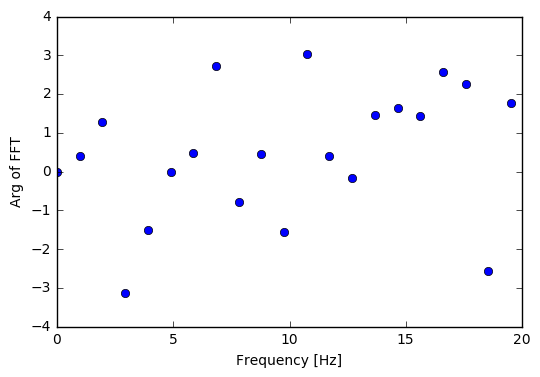

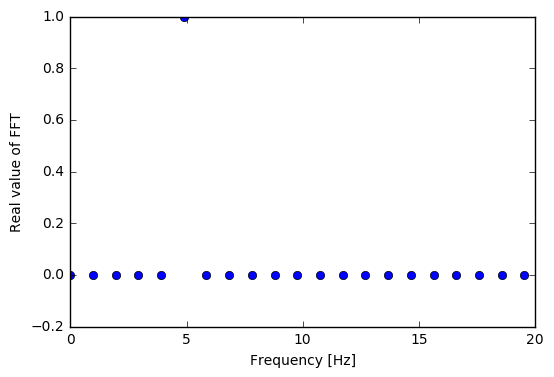

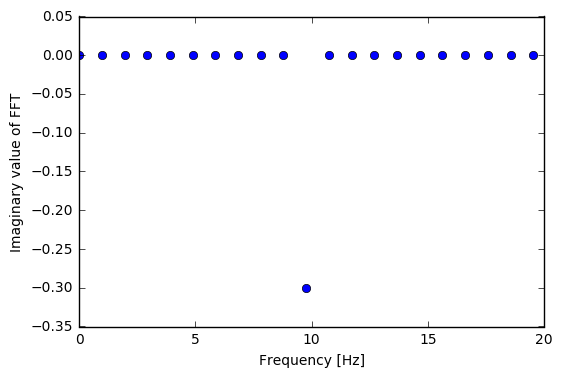

In [8]:
def plotFFT(y):

    # Calculate the FFT, normalise it, then plot.
    
    fft = np.fft.rfft(y) * 2 / numSamples

    plt.plot(f, abs(fft), 'o')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Absolute value of FFT")
    plt.xlim(0,20)
    plt.show()

# Plot it again, this time zooming in on the relevant section.

    plt.plot(f, np.angle(fft), 'o')
    plt.xlim(0, 20)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Arg of FFT")
    plt.show()

    plt.plot(f, np.real(fft), 'o')
    plt.xlim(0, 20)
    plt.ylabel("Real value of FFT")
    plt.xlabel("Frequency [Hz]")
    plt.show()

    plt.plot(f, np.imag(fft), 'o')
    plt.xlim(0, 20)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Imaginary value of FFT")
    plt.show()

# Now actually plot a signal! You should edit y0 to be y1, y2, and then y3, and
# examine the differences.

plotFFT(y1)

# Noise

The above discussion has concentrated on examining clear sinusoidal signals, but what happens if the samples are noisy?

## White noise

Let's begin with two sine-waves (once again chosen to have an integral number of cycles in our sample window) with some Gaussian noise added.

the 1st frequency is 4.8828125 Hz
the 2nd frequency is 400.390625 Hz


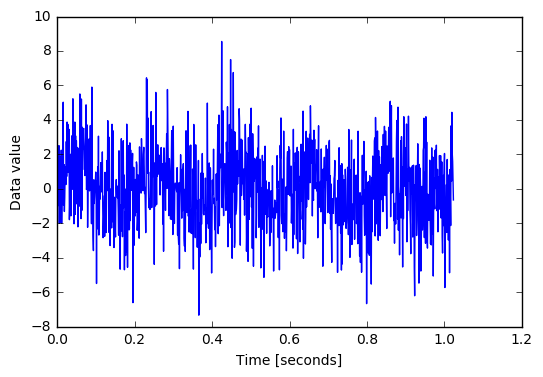

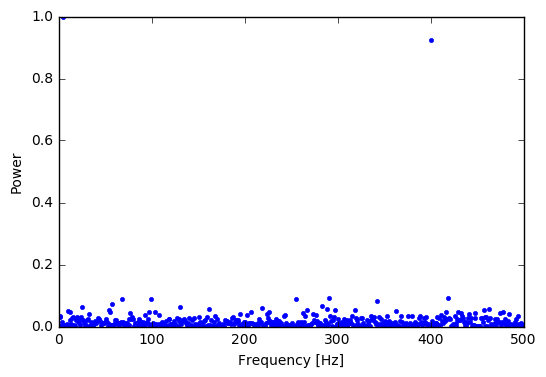

In [9]:
# Choose a couple of frequencies, one low, one high.

freq1Hz = 5 / (1024 * 0.001)
print("the 1st frequency is", freq1Hz, "Hz")

freq2Hz = 410 / (1024 * 0.001)
print("the 2nd frequency is", freq2Hz, "Hz")

# Create the samples.

y = np.sin(2 * np.pi * freq1Hz * t) + np.sin(2 * np.pi * freq2Hz * t) + 2.0 * np.random.randn(numSamples) 

# And plot them.

plt.plot(t, y)
plt.xlabel("Time [seconds]")
plt.ylabel("Data value")
plt.show()

# Calculate the FFT, and plot its power spectrum.

fft = np.fft.rfft(y) * 2 / numSamples
plt.plot(f, abs(fft) ** 2, '.')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()


Note how the above plots show that the two signal frequencies near 5 and 400 Hz are clearly detected (although their power isn't exactly 1.0 since the added noise makes it difficult to estimate the amplitudes), and the noise (along the bottom of the plot) appears with roughly equal amplitude at all frequencies.

To make the frequency spectrum of the noise clearer, we can average over many random samples. You should try the following code snippet with various values of $n$ - the number of samples to average. Note the scaling on the $y$ axis.

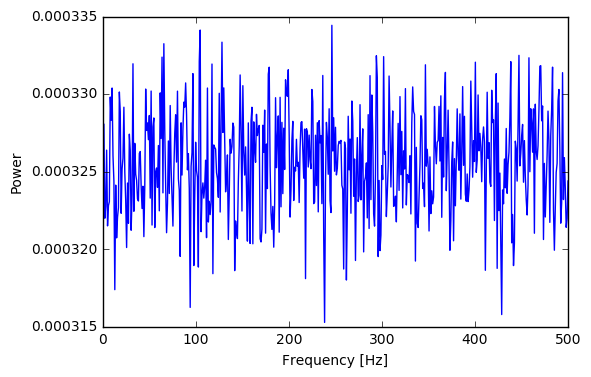

In [10]:
# This function creates n independent data samples 
# of length 1024, finds their FFT power spectrum, averages
# and plots it.

def plotAverageFFT(n):
    
    # Create the time and frequency arrays.
    
    numSamples = 1024
    dt = 0.001
    t = np.linspace(0, dt * (numSamples - 1), numSamples)
    f = np.fft.rfftfreq(t.size, dt)
    
    # We are going to calculate an average power spectrum,
    # so we begin by zeroing a suitably-sized array.
    
    powerSpectrum = np.zeros(f.size)

    # Now sum n power spectra. 
    
    for i in range(n):
        
        # Uncomment this line for Gaussian distributed samples.
        
        #y = np.random.randn(numSamples)
        
        # Uncomment this line for uniformly distributed samples.
        
        y = np.random.random(numSamples) - 0.5
        
        # Calculate the power spectrum and accumulate it.
        
        powerSpectrum += abs(np.fft.rfft(y) * 2 / numSamples) ** 2
        
    # Finally, divide by n to make the average.
    
    powerSpectrum /= n

    plt.plot(f, powerSpectrum)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power")

    plt.show()

plotAverageFFT(10000)

You can see from the above plot (noting that the y-axis doesn't start from zero) that the noise we added has a constant power (within the residual noise from averaging) for all frequencies, where the power is measured in bins of constant width (in Hz). 

Noise with a constant power like this is called *white noise*.  The fact that we used a *Gaussian* distribution of sample values at each point isn't important - all that matters for noise to be considered as *white* is that there is *no correlation* from one sample to the next. So we could have used any random distribution.

With white noise there is as much noise in the bin from 1-2 Hz as there is from 1,000,000-1,000,001 Hz.

## 1/f noise (pink noise)

In many physical systems, the noise isn't white, but increases to lower frequencies as $1/f$. This is called $1/f$ noise, or sometimes *pink noise*. With $1/f$ noise there is equal power in logarithmic space (or equivalently, per decade, or per octave), e.g., the noise power from 1-10 Hz is the same as from 1,000-10,000 Hz.

Generating pink noise in a computer is a little trickier than white noise. One algorithm for doing it, approximately, is the Voss-McCartney algorithm. We won't go into the details of how this works, but let's try it and see what happens.

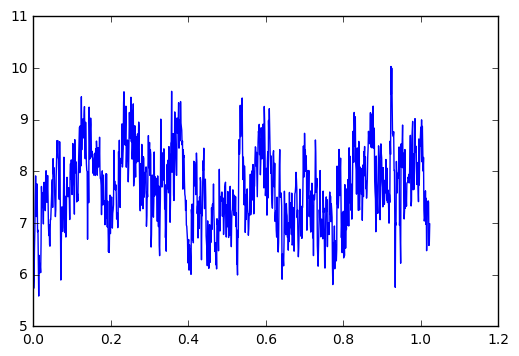

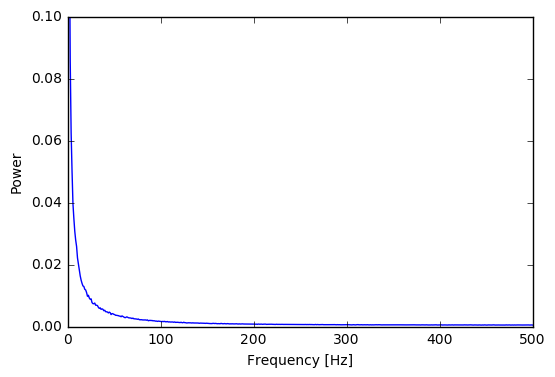

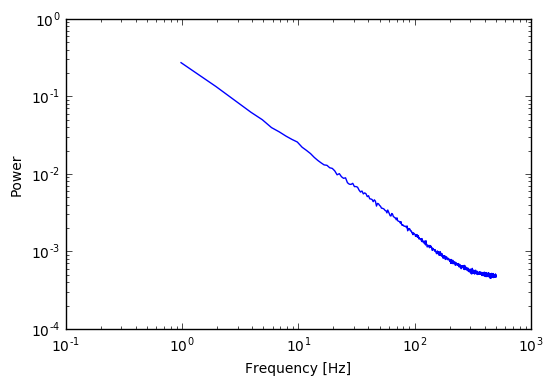

In [11]:
import pandas as pd

# This function generates an array of length nrows 
# containing 1/f noise.

def voss(nrows, ncols=16):
    
    # From Allen Downey, Think DSP
    
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

# Average and plot n power spectra, to make the 
# frequency spectrum clearer.

def plotAverageFFT(n):
    numSamples = 1024
    dt = 0.001
    t = np.linspace(0, dt * (numSamples - 1), numSamples)
    f = np.fft.rfftfreq(t.size, dt)
    
    # As before, let's calculate the average power 
    # spectrum for a number of samples.
    
    powerSpectrum = np.zeros(f.size)

    for i in range(n):

        # Generate the 1/f noise.
        
        y = voss(numSamples) 
        powerSpectrum += abs(np.fft.rfft(y) * 2 / numSamples) ** 2

    powerSpectrum /= n
    
    # Plot with linear axes.
    plt.plot(t, y)
    plt.show()
    
    plt.plot(f, powerSpectrum)
    plt.ylim(0.0,0.1)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power")
    plt.show()
    
    # A log-log plot shows the noise spectrum 
    # more clearly for 1/f noise.
    
    plt.plot(f, powerSpectrum)
    plt.loglog()
    plt.ylim(0.0001,1)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power")
    plt.show()

plotAverageFFT(1000)

You can see from the above plots how the noise follows a $1/f$ power spectrum - i.e., the slope is $-1$ in the log-log plot. Also note that the slope isn't perfect. I don't know if this is a limitation of the Voss-McCartney algorithm, or the finite length of time over which the noise is sampled.

## $1/f^2$ red noise

If the power spectrum slope goes as $1/f^2$ the noise is referred to as red noise, or sometimes brown noise (the "brown" comes from "Brownian motion", which generates this type of noise).

# Physical reasons for noise

## Shot noise (also known as photon noise, Poisson noise, or Schottky noise)

If the phenomenon under observation is inherently quantised (e.g., radioactive decay, the arrival of photons, the current due to electrons, rain drops on a roof), then the distribution of samples is given by Poissonion statistics.

The standard deviation of the samples in a Poisson distribution is given by $\sqrt N$ where $N$ is the number of samples. The signal-to-noise ratio is therefore ${\rm SNR}=N/\sqrt N=\sqrt N$, from which it is clear that shot noise only tends to be important when $N$ is small, so that the individual photons/electroncs/etc can be readily detected. At large values of $N$, other sources of noise will dominate.

Shot noise is an example of white noise, i.e., it has a constant power per Hz at all frequencies.

If you consider the flow of electron current in a wire, the mean square of the current noise caused by the discrete nature of the electrons is given by

$$\langle I^2_\hbox{noise}\rangle=2q\langle I\rangle\Delta f$$

where $q$ is the charge of an electron, $I$ is the current, and $\Delta f$ is the bandwidth of the measurement in Hz.


## Johnson noise (also known as thermal noise, or Nyquist noise)

Even if no net current is flowing in a wire, there will still be electrons randomly moving backwards and forwards along the wire as a result of their thermal velocity. This produces a current noise known as Johnson noise. It is normally expressed as the voltage developed across the wire's resistance:

$$\langle V^2_\hbox{noise}\rangle=4kTR\Delta f$$

where $k$ is Boltzman's constant, $T$ is the temperature of the resistor, $R$ its resistance, and $\Delta f$ is again the bandwidth of the measurement in Hz. Note that Johnson noise is independent of the current flow - the same amount of Johnson noise is superimposed on whatever DC current is flowing. Johnson noise provides a lower limit on the noise from a resistor; as the current increases, shot noise (and $1/f$ noise, see below) will kick in.

Like shot noise, Johnson noise is an example of white noise.

## $1/f$ noise (also known as flicker noise, or switching noise)

Many physical systems exhibit $1/f$ noise, and the reasons are many and varied, and not always obvious.

In the case of current flow through conductors, $1/f$ noise appears to result from fluctuations in *conductivity* due to thermal activation/deactivation of defects in the conductor.

In a perfect world a conductor would be perfect metal lattice, and electrons would flow smoothly. In reality, the lattices contain *defects* such as missing atoms, dopant atoms, grain boundaries, and so on. These defects act to scatter electrons, and hence reduce the conductivity. Furthermore, the defects can be in various states depending on temperature, with various relaxation times to lower energy states, and the states have different scattering cross sections for electrons. The end result is that the conductivity fluctuates in a random manner, and with a temperature dependence. Also, as the average DC current increases, the $1/f$ voltage noise increases since a given change in conductivity will cause a proportionally greater change in voltage.

At low temperatures, the higher energy states are not accessible, and you can be in the regime where the jumps in conductivity are easily visible. The same thing can happen if the current is flowing through a very narrow cross-section, such that a few defects can dominate the conductivity.

Unlike Johnson noise, $1/f$ noise is dependent on the physical type of resistor or component under consideration. Annealing a metal film tends to reduce the number of defects, so $1/f$ noise is reduced. Conversely, radiation damage can create defects that lead to an increase in $1/f$ noise.

$1/f$ noise occurs in something as simple as a switch contact (hence the term *switching noise*) as a result of the small cross-section where current has to flow. To reduce this effect, switches can be made with multiple parallel contacts to increase the area.

## Interesting sources of noise

Physics experiments quite often have to work close to the limit of what is possible. As such, minimising noise is something that physicists are often obsessed by. Over the years we tend to accummulate "war stories" describing particularly tricky noise problems that we have overcome. Here are some examples:

- Semiconductors are sensitive to light, and so they are usually encapsulated in opaque plastic or ceramic packages. If light can somehow still reach the semiconductor, you may see some unexpected effects, such as 100 Hz oscillation from fluorescent lamps. Be aware that black electrical tape is opaque in the visible, but to some extent transparent to infrared.

- Mechanical vibration can cause induced currents resulting from electric fields and changing capacitances. This is sometimes referred to as "microphonics" since the circuit can pick up sounds waves and act as a microphone.

- The tribolectric effect generates current when two dissimilar objects make contact and move relative to each other. This movement can be as simple as the bending of a cable consisting of a conductor and an insulator. As such, the triboelectric effect is another way for mechanical vibration to cause voltage noise.

- Junctions between dissimilar metals will also generate a voltage through the thermoelectric effect. If the temperature is fluctuating, you will see an apparent voltage noise. While this is usually at a fairly low frequency (due to typical thermal time constants) it can be short if the volumes of metal at the junctions are small. 

- See [this article by Nic Bingham and myself](http://mcba11.phys.unsw.edu.au/~plato-a/papers/bin14a.pdf) on how an interesting noise problem was solved.

- Any wire in an electric circuit can act as an aerial to pick up stray electric and magentic field fluctuations, e.g., from radio/TV stations, mains wiring, lightning, etc.

- Magnetic coupling. While a Faraday cage will stop electric fields, magnetic fields will pass right through. Mu-metal is a magnetic alloy of nickel and iron that has a very high permeability, and will greatly attenuate low intensity magnetic fields. Mu-metal is also expensive, and looses its nice properties if hammered or repeatedly bent.

- Current may flow in wires that are connecting points in a circuit that are nominally at the same potential. You may think that the "ground" is 0V everywhere in your circuit, but there could be substantial differences.

- The path that current takes depends on the frequency. Low frequency current can spread out over large areas, whereas high-frequency current may be isolated to the surface ("skin-effect") and use only a fraction of the conductor area.

## Techniques for making low noise measurements

To be completed...

- careful design of the "front-end", the first amplifier in the measurement chain
- careful attention to "ground loops"
- bandwidth limiting
- lock-in detection
